In [18]:
!nvidia-smi

Wed Nov 10 13:29:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparation

## Import packages

In [6]:
import os, sys
from osgeo import gdal
from osgeo import gdalconst
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import math
import copy
import time

In [7]:
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import merge, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

## Read input

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Band 1: blue; Band 2: green; Band 3: red; Band 4: nir
I = np.load(os.path.join('/content/drive/MyDrive/vsyrris/Netherlands/Training.npy'))
I.shape
#https://cidportal.jrc.ec.europa.eu/services/webview/jeodpp/ml-showcase/

(4, 3344, 244, 244)

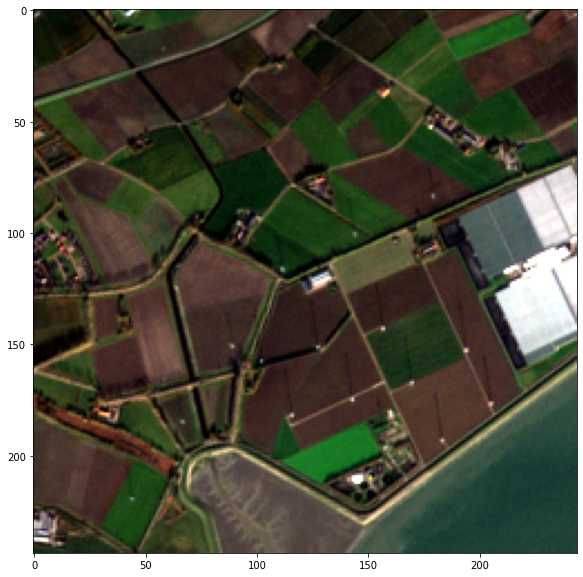

In [10]:
idx = 50
tmp = np.zeros((I.shape[2], I.shape[3], 3), dtype=np.uint8)
for q in range(3):
    a = copy.copy(I[q,idx,:,:])
    D = a>0
    prc = np.percentile(a[D],[1,99])
    tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
plt.imshow(tmp)
f = plt.gcf()
f.set_size_inches(10, 10)
plt.show()

In [11]:
T = np.load('/content/drive/MyDrive/vsyrris/Netherlands/Targets.npy')
T.shape

(3344, 244, 244)

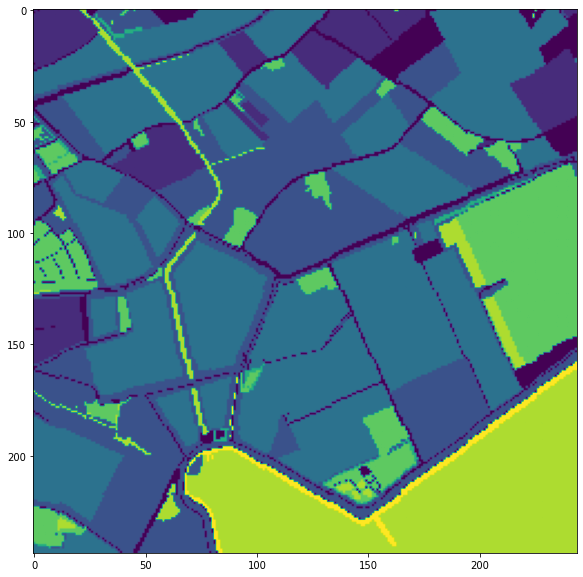

In [12]:
plt.imshow(T[idx,:,:])
f = plt.gcf()
f.set_size_inches(10, 10)
plt.show()

In [13]:
# Class 0 signifies nodata
classes = np.unique(T.flatten())
print(classes)

[0 1 2 3 4 5 6 7 8]


# Standardize data

In [14]:
X = np.float32(I)
X[X>10000] = 10000
X = X / 10000.
X.shape

(4, 3344, 244, 244)

In [15]:
X = np.rollaxis(X, 0, 4)
xshape = X.shape
print(xshape)

(3344, 244, 244, 4)


In [16]:
mu = np.zeros((4,))
std = np.zeros((4,))
for q in range(X.shape[3]):
    tmp = copy.copy(X[:, :, :, q])
    tmp = tmp.flatten()
    mu[q] = tmp[tmp>0].mean()
    std[q] = tmp[tmp>0].std()
    print(mu[q], std[q])
    tmp[tmp>0] = (tmp[tmp>0] - mu[q]) / std[q]
    X[:, :, :, q] = tmp.reshape(X.shape[0], X.shape[1], X.shape[2])
    del tmp

0.12655076384544373 0.016980711370706558
0.09710454940795898 0.016959035769104958
0.07182221114635468 0.023930516093969345
0.17956602573394775 0.12075547128915787


In [17]:
np.save('params_std', np.vstack((mu, std)))

# Prepare targets

In [18]:
del I

In [19]:
Y = np.zeros(T.shape +  (len(classes),), dtype=np.uint8)
for q in range(len(classes)):
    tmp = Y[:,:,:,q]
    tmp[T==q] = 1
    Y[:,:,:,q] = tmp
print(Y.shape)

(3344, 244, 244, 9)


In [20]:
del T

# U-net

In [21]:
filters = [32, 64, 128, 256, 512, 512, 856]

def unet(input_size):
    inputs = Input(input_size)
    conv1 = Conv2D(filters[0], (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(filters[0], (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters[1], (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(filters[1], (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filters[2], (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(filters[2], (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(filters[3], (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(filters[3], (3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(filters[4], (3,3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(filters[4], (3,3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = Conv2D(filters[5], (3,3), activation='relu', padding='same')(pool5)
    conv6 = Conv2D(filters[5], (3,3), activation='relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    conv7 = Conv2D(filters[6], (3,3), activation='relu', padding='same')(pool6)
    conv7 = Conv2D(filters[6], (3,3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Lambda(lambda image: tf.image.resize(image, (7, 7)))(up8)
    merge8 = concatenate([conv6,up8], axis = 3)
    conv8 = Conv2D(filters[5], (3,3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(filters[5], (3,3), activation='relu', padding='same')(conv8)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Lambda(lambda image: tf.image.resize(image, (15, 15)))(up9)
    merge9 = concatenate([conv5,up9], axis = 3)
    conv9 = Conv2D(filters[4], (3,3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(filters[4], (3,3), activation='relu', padding='same')(conv9)
    
    up99 = UpSampling2D(size=(2, 2))(conv9)
    merge99 = concatenate([conv4,up99], axis = 3)
    conv99 = Conv2D(filters[3], (3,3), activation='relu', padding='same')(merge99)
    conv99 = Conv2D(filters[3], (3,3), activation='relu', padding='same')(conv99)
    
    up10 = UpSampling2D(size=(2, 2))(conv99)
    up10 = Lambda(lambda image: tf.image.resize(image, (61, 61)))(up10)
    merge10 = concatenate([conv3,up10], axis = 3)
    conv10 = Conv2D(filters[2], (3,3), activation='relu', padding='same')(merge10)
    conv10 = Conv2D(filters[2], (3,3), activation='relu', padding='same')(conv10)

    up11 = concatenate([UpSampling2D(size=(2, 2))(conv10), conv2], axis = 3)
    conv11 = Conv2D(filters[1], (3,3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(filters[1], (3,3), activation='relu', padding='same')(conv11)

    up12 = concatenate([UpSampling2D(size=(2, 2))(conv11), conv1], axis = 3)
    conv12 = Conv2D(filters[0], (3,3), activation='relu', padding='same')(up12)
    conv12 = Conv2D(filters[0], (3,3), activation='relu', padding='same')(conv12)

    conv13 = Conv2D(len(classes), 1, activation = 'softmax')(conv12)

    model = Model(inputs, conv13)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

input_shape = (xshape[1], xshape[2], xshape[3])
model = unet(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 244, 244, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 244, 244, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [22]:
batch_size = 25
epochs = 2

fnmodel = 'MODEL_UNET'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(fnmodel, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [ ]:
t = time.time()
print(fnmodel)
history = model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=1, 
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.2)
print('Elapsed time for training: %.02f sec' % (time.time() - t))

MODEL_UNET
